<a href="https://colab.research.google.com/github/escapingLife/mashinePrograming/blob/master/10%EC%A3%BC%EC%B0%A8/Simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# -----------------------------------------------------------
# 라이브러리 임포트
# -----------------------------------------------------------
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------------------------------------
# 개별 파일 읽기
# -----------------------------------------------------------
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# -----------------------------------------------------------
# 여러 파일을 읽어서 3차원 배열로 합치기
# -----------------------------------------------------------
def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(os.path.join(prefix, name))
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

# -----------------------------------------------------------
# train/test 그룹별 데이터 로드
# -----------------------------------------------------------
def load_dataset_group(group, dataset_path):
    signals_path = os.path.join(dataset_path, group, 'Inertial Signals')
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt',  'body_acc_y_'+group+'.txt',  'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, signals_path)
    y = load_file(os.path.join(dataset_path, group, 'y_'+group+'.txt'))
    return X, y

# -----------------------------------------------------------
# 전체 데이터셋 로드
# -----------------------------------------------------------
def load_dataset(dataset_path):
    trainX, trainy = load_dataset_group('train', dataset_path)
    testX, testy = load_dataset_group('test', dataset_path)

    # 라벨 보정
    trainy = trainy - 1
    testy = testy - 1

    # 원-핫 인코딩
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print(f"trainX: {trainX.shape}, trainy: {trainy.shape}")
    print(f"testX: {testX.shape}, testy: {testy.shape}")
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

# -----------------------------------------------------------
# 실행: 데이터 로드
# -----------------------------------------------------------
dataset_path = r"/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset"
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(dataset_path)

/tmp/ipython-input-3933573458.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3933573458.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3933573458.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3933573458.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=Tr

trainX: (7352, 128, 9), trainy: (7352, 1)
testX: (2947, 128, 9), testy: (2947, 1)


/tmp/ipython-input-3933573458.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3933573458.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [34]:
# -----------------------------------------------------------
# train 데이터를 다시 train/validation으로 분리
# -----------------------------------------------------------
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

print("\n데이터 분할 결과:")
print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train_one_hot:", y_train_one_hot.shape, "y_val_one_hot:", y_val_one_hot.shape)


데이터 분할 결과:
X_train: (5881, 128, 9) X_val: (1471, 128, 9)
y_train_one_hot: (5881, 6) y_val_one_hot: (1471, 6)


In [35]:
# -----------------------------------------------------------
# 데이터 스케일링 (StandardScaler)
# -----------------------------------------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_val_scaled   = scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
testX_scaled   = scaler.transform(testX.reshape(-1, testX.shape[2])).reshape(testX.shape)

In [36]:
# -----------------------------------------------------------
# 입력/출력 차원 설정
# -----------------------------------------------------------
n_timesteps, n_features, n_outputs = X_train_scaled.shape[1], X_train_scaled.shape[2], y_train_one_hot.shape[1]


In [37]:
# -----------------------------------------------------------
# CNN 모델 정의 (고성능 버전)
# -----------------------------------------------------------
cnn_model = Sequential([
    # 블록 1
    Conv1D(128, kernel_size=7, activation='relu', input_shape=(n_timesteps, n_features)),
    BatchNormalization(),
    Dropout(0.3),

    # 블록 2
    Conv1D(256, kernel_size=5, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # 블록 3
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # 특징 맵 평균화 (Flatten 대신)
    GlobalAveragePooling1D(),

    # 완전 연결층
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(n_outputs, activation='softmax')
])

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 122, 128)       │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 122, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 122, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 118, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 118, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 118, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 116, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 116, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 116, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,486 (1.30 MB)

 Trainable params: 338,950 (1.29 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [38]:
# -----------------------------------------------------------
# 조기 종료 콜백
# -----------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [39]:
# -----------------------------------------------------------
# 학습
# -----------------------------------------------------------
history = cnn_model.fit(
    X_train_scaled, y_train_one_hot,
    epochs=80,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_one_hot),
    callbacks=[es],
    verbose=1
)

Epoch 1/80
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.7860 - loss: 0.6013 - val_accuracy: 0.9375 - val_loss: 0.2109
Epoch 2/80
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9299 - loss: 0.1870 - val_accuracy: 0.9354 - val_loss: 0.1210
Epoch 3/80
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9369 - loss: 0.1576 - val_accuracy: 0.9395 - val_loss: 0.1419
Epoch 4/80
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9462 - loss: 0.1415 - val_accuracy: 0.9483 - val_loss: 0.1103
Epoch 5/80
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9442 - loss: 0.1394 - val_accuracy: 0.9483 - val_loss: 0.1351
Epoch 6/80
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9462 - loss: 0.1443 - val_accuracy: 0.9545 - val_loss: 0.1212
Epoch 7/80
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9473 - loss: 0.1260 - val_accuracy: 0.9565 - val_loss: 0.1063
Epoch 8/80
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9486 - loss: 0.1256 - val_accuracy: 

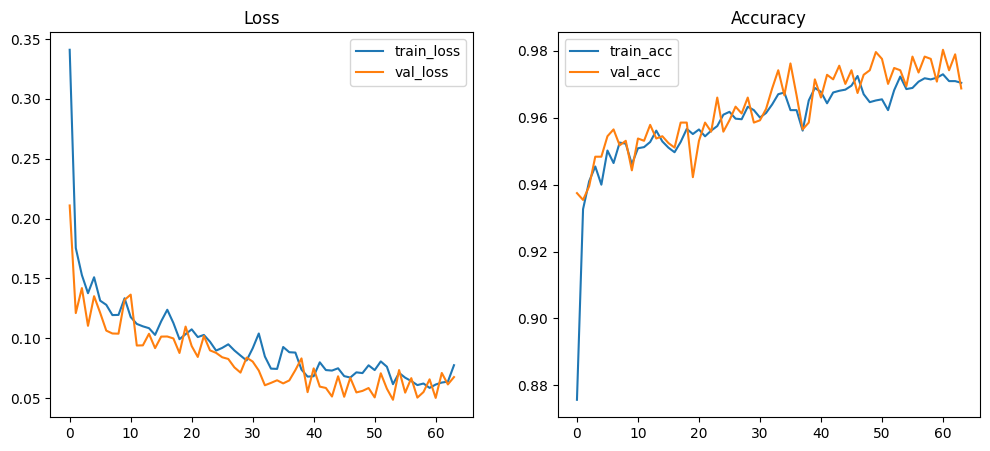

In [40]:
# -----------------------------------------------------------
# 손실 및 정확도 시각화
# -----------------------------------------------------------
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [41]:
# -----------------------------------------------------------
# 테스트 데이터 평가
# -----------------------------------------------------------
pred = cnn_model.predict(testX_scaled)
pred_classes = np.argmax(pred, axis=1)

cm = confusion_matrix(testy, pred_classes)
acc = accuracy_score(testy, pred_classes)

print(f"\nTest Accuracy: {acc * 100:.2f} %")
print(classification_report(testy, pred_classes))

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Test Accuracy: 92.47 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       0.97      0.95      0.96       471
           2       0.95      0.97      0.96       420
           3       0.87      0.72      0.79       491
           4       0.79      0.90      0.84       532
           5       0.99      1.00      0.99       537

    accuracy                           0.92      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.92      0.92      2947



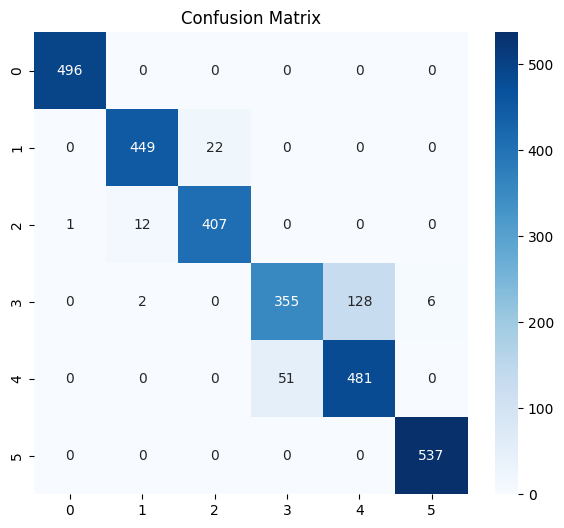

In [42]:
# -----------------------------------------------------------
# 혼동 행렬 시각화
# -----------------------------------------------------------
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()